# Example charge diagram

In [12]:
import os

from qcodes import Station, load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.data_set import load_by_run_spec
 
import nanotune as nt
from nanotune.tests.mock_classifier import MockClassifer
from nanotune.tuningstages.chargediagram import ChargeDiagram
from nanotune.tuningstages.settings import DataSettings, SetpointSettings, Classifiers
from nanotune.device.device import Readout, NormalizationConstants

from sim.data_providers import QcodesDataProvider
from sim.qcodes_mocks import MockDoubleQuantumDotInstrument

nt_path = os.path.dirname(os.path.dirname(os.path.abspath(nt.__file__)))

Define databases

In [2]:
db_name_original_data2D = "dot_tuning_sequences.db"
db_folder_original_data = os.path.join(nt_path, "data", "tuning")
chargediagram_path = os.path.join(db_folder_original_data, db_name_original_data2D)

db_name_replay = 'qdsim_test.db'
db_folder_replay = os.getcwd()

Create qc.Station

In [3]:
station = Station()

qd_mock_instrument = MockDoubleQuantumDotInstrument()
station.add_component(qd_mock_instrument, name="qdmock")

qdsim = qd_mock_instrument.mock_device

Create the data provider

In [4]:
charge_state_data = QcodesDataProvider(
    input_providers=[qdsim.left_plunger, qdsim.right_plunger], 
    db_path=chargediagram_path, 
    exp_name="GB_Newtown_Dev_1_1", 
    run_id = 19,
)
qd_mock_instrument.drain.set_data_provider(charge_state_data)

In [5]:
ds = nt.Dataset(19, db_name_original_data2D, db_folder_original_data)
range_to_sweep = [
    (min(ds.data.voltage_x.values), max(ds.data.voltage_x.values)),
    (min(ds.data.voltage_y.values), max(ds.data.voltage_y.values)),
]
# range_to_sweep

In [6]:
nt.set_database(db_name_replay, db_folder_replay)
exp = load_or_create_experiment("simtest")

In [17]:

chadiag = ChargeDiagram(
    data_settings=DataSettings(
        db_name=db_name_replay,
        db_folder=db_folder_replay,
        normalization_constants=NormalizationConstants(**ds.normalization_constants),
        segment_size=0.2,
    ),
     setpoint_settings=SetpointSettings(
        voltage_precision=0.01,
        parameters_to_sweep=[qd_mock_instrument.left_plunger, qd_mock_instrument.right_plunger],
        safety_voltage_ranges=[(-3, 0)],
        ranges_to_sweep=range_to_sweep,
    ),
    readout=Readout(transport=qd_mock_instrument.drain),
    classifiers=Classifiers(
        singledot=MockClassifer('singledot'),
        doubledot=MockClassifer('doubledot'),
        dotregime=MockClassifer('dotregime')),
)

Starting experimental run with id: 2. 
Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 175.78it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 56.43it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 102.07it/s]
Starting experimental run with id: 1. 
Starting experimental run with id: 2. 
Starting experimental run with id: 3. 
Starting experimental run with id: 4. 
Starting experimental run with id: 5. 
Starting experimental run with id: 6. 


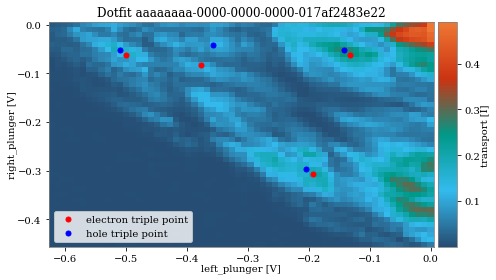

chargediagram: Good result measured. Regime: doubledot. Termination reasons: None. 


In [18]:
tuning_result = chadiag.run_stage()

In [19]:
tuning_result.success

True

In [20]:
# Note that a mock classifier was used, which always returns True == good result
tuning_result.ml_result

{'dot_segments': {1: {'voltage_ranges': [(-0.622073578595318,
     -0.428312955754153),
    (-0.451505016722408, -0.236013986013986)],
   'predicted_regime': 3},
  2: {'voltage_ranges': [(-0.622073578595318, -0.428312955754153),
    (-0.225752508361204, 0.0)],
   'predicted_regime': 3},
  3: {'voltage_ranges': [(-0.418115028236197, -0.224354405395033),
    (-0.451505016722408, -0.236013986013986)],
   'predicted_regime': 3},
  4: {'voltage_ranges': [(-0.418115028236197, -0.224354405395033),
    (-0.225752508361204, 0.0)],
   'predicted_regime': 3},
  5: {'voltage_ranges': [(-0.214156477877077, 0.0),
    (-0.451505016722408, -0.236013986013986)],
   'predicted_regime': 3},
  6: {'voltage_ranges': [(-0.214156477877077, 0.0), (-0.225752508361204, 0.0)],
   'predicted_regime': 3}},
 'regime': 'doubledot',
 'quality': True,
 'features': {'transport': {'triple_points': [([0.01446705392538605, None],
     [0.010197927517956007, 0.010261477652781958],
     [-0.193760622841165, -0.3078443295834

In [21]:
tuning_result.data_ids

[2]